# roAp Classification of NGC 2264 using Vectorization
### $->$ Not using regressions, like in CS 455 project.

In [2]:
# General packages
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from sympy import *
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

### 1. Importing csv files containing NGC 2264 and known roAps
        'roAp' is the csv file including the field roAps
        'clust' is the csv file including NGC 2264 cluster stars

In [3]:
r = pd.read_csv('Data/field_roAp_gaiaNstarhorse.csv', index_col=False)
c = pd.read_csv('Data/NGC2264_StarhorseNGaia.csv', index_col=False)
rfeat = r.columns
cfeat = c.columns
# Dataframe of each dataset
roAp = pd.DataFrame(r)
clust = pd.DataFrame(c)
# Extracting features of all datasets
yr = (roAp['GMAG0']).values
yc = (clust['GMAG0']).values
xr = (roAp['BP-RP0']).values
xc = (clust['BP-RP0']).values

print('Total Dataset for field roAps:', roAp.shape)
print('Total Dataset for Cluster:', clust.shape)

Total Dataset for field roAps: (87, 120)
Total Dataset for Cluster: (961, 145)


#### 1.1 Transposing x and y datasets, calculating the angle between cluster and roAp positions, and calculating the resultant vector between cluster and roAp stars.

In [4]:
# For roAp dataset
xr_array = np.array([xr])
xrp_array = xr_array.transpose()

yr_array = np.array([yr])
yrp_array = yr_array.transpose()

# For cluster dataset
xc_array = np.array([xc])
yc_array = np.array([yc])

# Only transposing one so that we can evenly distribute the values
xrc = (xrp_array-xc_array)
yrc = (yrp_array-yc_array)
print('Complete BP-RP shape:',xrc.shape)
print('Complete GMAG shape:',yrc.shape)
# Finding the angle using arctan(opposite/adjacent)
theta = np.arctan(yrc/xrc)
theta = np.array(theta)
rd = (xrc**2+yrc**2)**(1/2) # Resultant vector for the distance between cluster and roAp stars

Complete BP-RP shape: (87, 961)
Complete GMAG shape: (87, 961)


#### 1.2 Making roAp and cluster sigma NxM arrays so vectorization may be done

In [5]:
# Error values for roAp and cluster
gmre = np.array([(roAp['phot_g_mean_mag_error'])])
bp_rp_re = np.array([((roAp['phot_bp_mean_mag_error']))-((roAp['phot_rp_mean_mag_error']))])
gmce = np.array([(clust['phot_g_mean_mag_error'])])
bp_rp_ce = np.array([((clust['phot_bp_mean_mag_error']))-((clust['phot_rp_mean_mag_error']))])
# Squaring all terms
sq_gmre = gmre**2
sq_bp_rp_re = bp_rp_re**2
sq_gmce = gmce**2
sq_bp_rp_ce = bp_rp_ce**2
# Transposing roAp array 
gmre_p = (sq_gmre.transpose())
bp_rp_rep = (sq_bp_rp_re.transpose())
# Sigma squared terms
gme = (gmre_p+sq_gmce)
bp_rp_e = (bp_rp_rep+sq_bp_rp_ce)
# Calculating sqrt(Sigma) from all errors
sig_gme = (gme)**(1/2)
sig_bp_rp_e = (bp_rp_e)**(1/2)
print('GMAG Sigma shape:',sig_gme.shape, '\nBP-RP Sigma shape:',sig_bp_rp_e.shape)

GMAG Sigma shape: (87, 961) 
BP-RP Sigma shape: (87, 961)


#### 2.0 Plotting the CMD to give visual of data to be analyzed

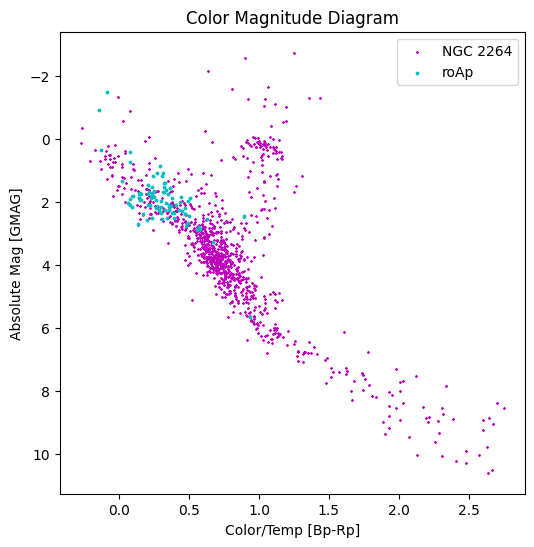

In [6]:
fig, ax = plt.subplots(1,figsize=(6,6))

plt.scatter(x=xc,y=yc,marker='*',c='m',label='NGC 2264',s=1)
plt.scatter(x=xr,y=yr,c='c',label='roAp',s=3)

plt.gca().invert_yaxis()

plt.title('Color Magnitude Diagram')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend(loc='best')
plt.savefig('Data/CMD with Error Ellipses')
plt.show()

#### 2.1 Calculating resultant vector from edge of the ellipse, given the sigma and angle of each value

In [7]:
# Making the Ellipse Equation
sigma = []
a = sig_gme
b = sig_bp_rp_e
yD = a*(np.sin(theta))
xD = b*(np.cos(theta))
rD = (xD**2+yD**2)**(1/2) # Resultant vector for the edge of the ellipse

#### 2.2 Plotting single Error ellipse to show concept

<Axes.ArtistList of 1 patches>


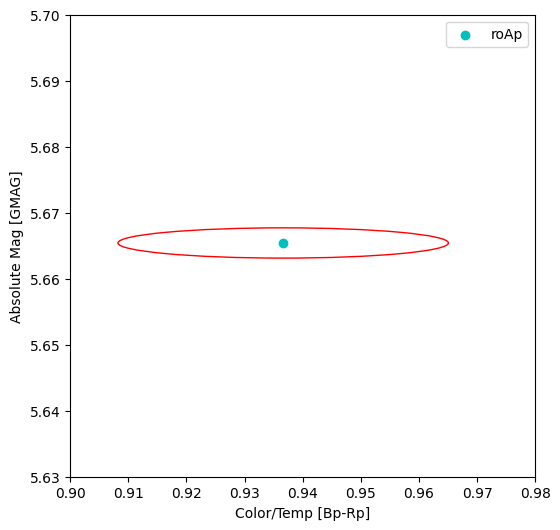

In [8]:
a0 = (a[0][0])
b0 = (b[0][0])
xr0 = (roAp['BP-RP0'])[0]
yr0 = (roAp['GMAG0'])[0]

fig, ax = plt.subplots(1,figsize=(6,6))

ellipse = mpatches.Ellipse(xy=(xr0,yr0),width=b0,height=a0)
ax.add_patch(ellipse)
ellipse.set_facecolor('None')
ellipse.set_edgecolor('r')
print(ax.patches)

plt.scatter(xr0,yr0,c='c',label='roAp')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.xlim(0.9,0.98)
plt.ylim(5.63,5.7)
plt.legend(loc='best')
plt.show()

#### 2.4 Calculating $n\cdot\sigma$ tolerance ellipses with roAp and cluster sigmas

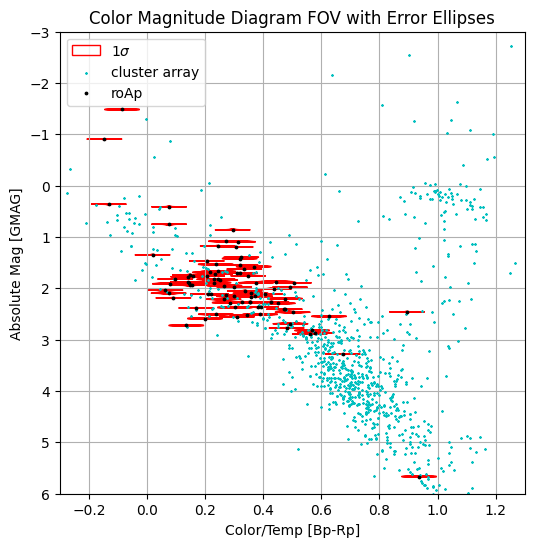

In [9]:
fig, ax = plt.subplots(1,figsize=(6,6))

# Making a for loop to draw an ellipse around each roAp data point
ellipse0 = []
n = 1 # User change the number of sigmas

ellipse0 = [mpatches.Ellipse(xy=((roAp['BP-RP0'])[p],(roAp['GMAG0'])[p]),width=(n*b)[p][i],height=(n*a)[p][i])
           for p in range(len(xr)) for i in range(len(xc))]

for e in ellipse0:
    ax.add_artist(e)
    e.set_facecolor(color='None')
    e.set_edgecolor('r')
e.set_label(f'{n}$\sigma$')

plt.scatter(x=xc,y=yc,marker='*',c='c',label='cluster array',s=1,zorder=2)
plt.scatter(x=xr,y=yr,c='black',label='roAp',s=3,zorder=3)

plt.gca().invert_yaxis()

plt.title('Color Magnitude Diagram FOV with Error Ellipses')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.grid(zorder=1)
plt.legend(loc='best')
plt.xlim(-.3,1.3)
plt.ylim(6,-3)
plt.savefig('Data/CMD with Tolerance Ellipses')
plt.show()

In [10]:
gmcet = gmce.transpose()
bp_rp_cet = bp_rp_ce.transpose()
# R squared values for Cluster and roAp mag error
cands = []
# Calculating the averages
avgx = np.mean(xr)
avgy = np.mean(yr)
# Doing vectorization to classify candidates
for q in range(len(xc)):
    for i in range(len(xr)):
        if abs(rD[i][q]) >= abs(rd[i][q]):
            cand = clust.iloc[q]['id']
            cands.append({'ID':cand,'Designation':(clust['designation'])[q],'GMAG':(clust['GMAG0'])[q],'GMAG_Error':(gmcet)[q],
                        'BP-RP':(clust['BP-RP0'])[q],'BP-RP_Error':(bp_rp_cet)[q],'Ratio_to_Sigma':((rd)[i][q])/((rD)[i][q])})
cands = pd.DataFrame(cands)
cands.to_csv('Data/roAp_NGC2264_Candidates.txt')
cands.to_csv('Data/roAp_NGC2264_Candidates.csv')
cands.head(n=len(cands))

,ID,Designation,GMAG,GMAG_Error,BP-RP,BP-RP_Error,Ratio_to_Sigma
0,123,Gaia DR3 3326710143670027648,2.527593,[0.003307],0.345422,[0.060566999999999996],0.900398
1,123,Gaia DR3 3326710143670027648,2.527593,[0.003307],0.345422,[0.060566999999999996],0.893433
2,209,Gaia DR3 3326715331990631936,1.167866,[0.003333],0.194945,[0.061409000000000005],0.794189
3,249,Gaia DR3 3326717462294179840,2.681170,[0.003058],0.499810,[0.030315999999999996],0.464973
4,434,Gaia DR3 3326738456092866560,3.276587,[0.00317],0.672407,[0.017624],0.324124
5,488,Gaia DR3 3326740139720070144,2.703486,[0.002949],0.484801,[0.036441999999999995],0.942716
6,565,Gaia DR3 3326743094657977472,1.676147,[0.003534],0.274794,[0.076086],0.702303
7,565,Gaia DR3 3326743094657977472,1.676147,[0.003534],0.274794,[0.076086],0.800858
8,565,Gaia DR3 3326743094657977472,1.676147,[0.003534],0.274794,[0.076086],0.392735
9,565,Gaia DR3 3326743094657977472,1.676147,[0.003534],0.274794,[0.076086],0.761297


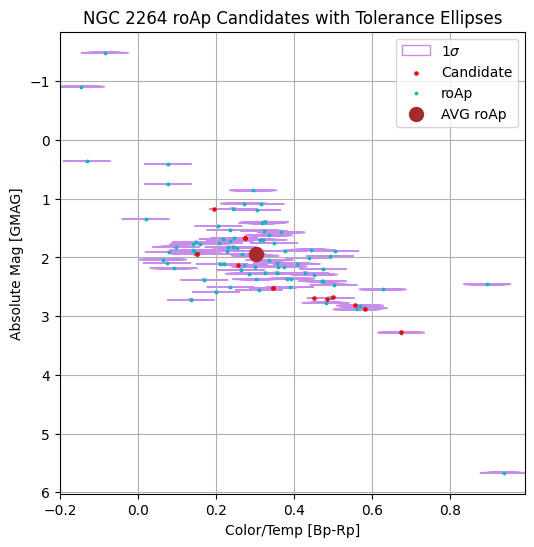

In [11]:
ub = cands['BP-RP']
ua = cands['GMAG']
fig, axes = plt.subplots(1,figsize=(6,6))

ellipse0 = [mpatches.Ellipse(xy=((roAp['BP-RP0'])[p],(roAp['GMAG0'])[p]),width=(n*b)[p][i],height=(n*a)[p][i])
           for p in range(len(xr)) for i in range(len(xc))]

for e1 in ellipse0:
    axes.add_artist(e1)
    e1.set_facecolor(color='None')
    e1.set_edgecolor('#c88ced')
e1.set_label(f'{n}$\sigma$')

plt.scatter(ub,ua,c='red',label='Candidate',s=5,zorder=3)
plt.scatter(x=xr,y=yr,c='c',label='roAp',s=3,zorder=2)
plt.scatter(avgx,avgy,c='brown',s=100,label='AVG roAp',zorder=2)
plt.gca().invert_yaxis()

plt.title('NGC 2264 roAp Candidates with Tolerance Ellipses')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.grid(zorder=1)
plt.legend(loc='best')
plt.savefig('Data/CMD with Cands')
plt.show()